In [19]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, MarkerCluster
from IPython.display import display, Markdown

In [ ]:
#Reading and Cleaning Data
acled_data = pd.read_csv('./ACLED_DATA_PREVIOUSYEAR.csv') 
gdf = gpd.GeoDataFrame(
    acled_data, geometry=gpd.points_from_xy(acled_data.longitude, acled_data.latitude), crs="EPSG:4326"
)
filtered_gdf = gdf[gdf['fatalities']>0]
ua = gpd.read_file("./ua.json")

In [21]:
def maximum_coverage(demand_points, facility_locations, num_facilities, service_radius):
    """
    Implements the maximum coverage algorithm.

    Args:
        demand_points: GeoDataFrame with demand points.
        facility_locations: GeoDataFrame with candidate facility locations.
        num_facilities: Number of facilities to select.
        service_radius: Service radius around each facility.

    Returns:
        GeoDataFrame of selected facilities.
    """

    selected_facilities = []
    covered_demand = []

    for _ in range(num_facilities):
        max_coverage = 0
        best_facility = None

        for _, facility in facility_locations.iterrows():
            if facility.geometry in selected_facilities:
                continue

            service_area = facility.geometry.buffer(service_radius)
            covered = demand_points[demand_points.geometry.within(service_area)]
            coverage = covered.shape[0]

            if coverage > max_coverage:
                max_coverage = coverage
                best_facility = facility

        if best_facility is not None:
            selected_facilities.append(best_facility.geometry)
            covered_demand.extend(covered_demand)

    return gpd.GeoDataFrame(geometry=selected_facilities, crs="EPSG:4326")

3142


<Axes: title={'center': 'November Incidents with > 1 Fatalities'}>

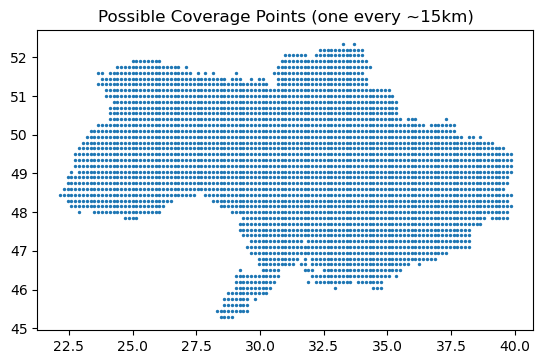

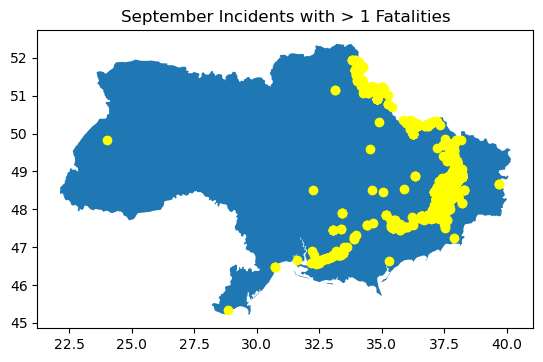

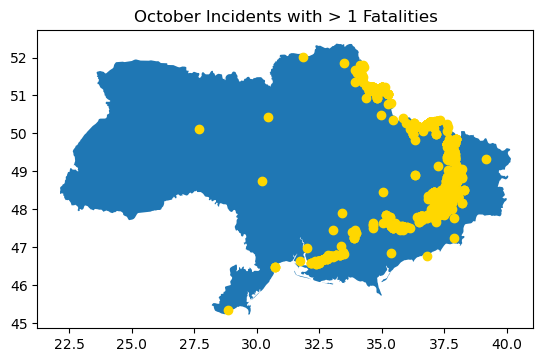

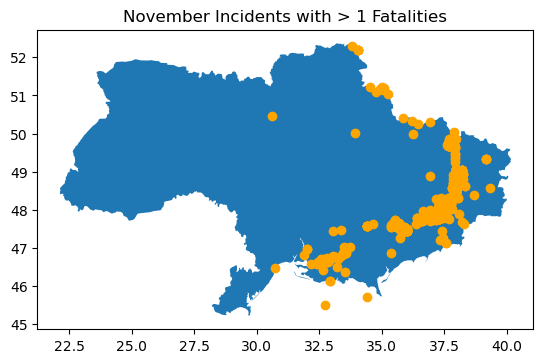

In [38]:
#Generate a 2D grid of points with a .15 degree step (about 15km)
x, y = np.meshgrid(np.arange(22,40.0, .15), np.arange(45.0, 53.0, .15))
x, y = x.flatten(), y.flatten()

possible_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x, y), crs="EPSG:4326"
)

#Clip points to those within Ukraine
clipped_points = possible_points.clip(ua) 

print(len(clipped_points))

f, ax = plt.subplots()
ax.title.set_text("Possible Coverage Points (one every ~15km)")
clipped_points.plot(ax=ax, markersize=2)

f, ax = plt.subplots()
ax.title.set_text("September Incidents with > 1 Fatalities")
ua.to_crs(filtered_gdf.crs).plot(ax=ax)
filtered_gdf[filtered_gdf['event_date'].str.contains("September")].plot(ax=ax, color="yellow")

f, ax = plt.subplots()
ax.title.set_text("October Incidents with > 1 Fatalities")
ua.to_crs(filtered_gdf.crs).plot(ax=ax)
filtered_gdf[filtered_gdf['event_date'].str.contains("October")].plot(ax=ax, color="gold")

f, ax = plt.subplots()
ax.title.set_text("November Incidents with > 1 Fatalities")
ua.to_crs(filtered_gdf.crs).plot(ax=ax)
filtered_gdf[filtered_gdf['event_date'].str.contains("November")].plot(ax=ax, color="orange")

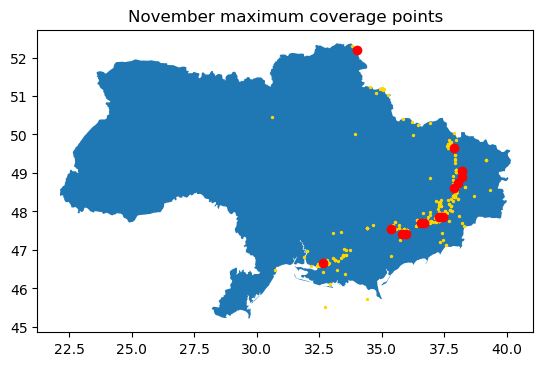

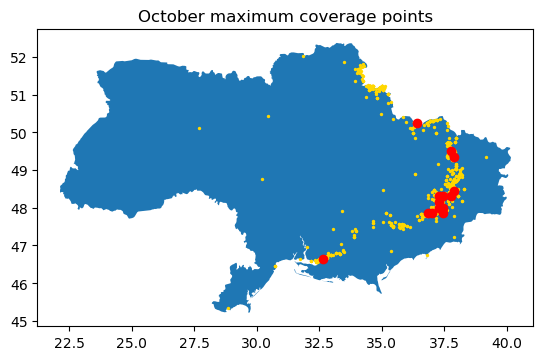

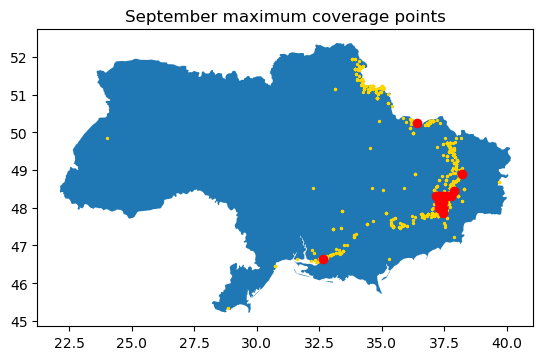

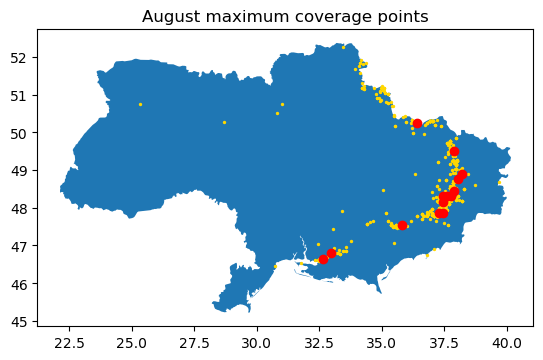

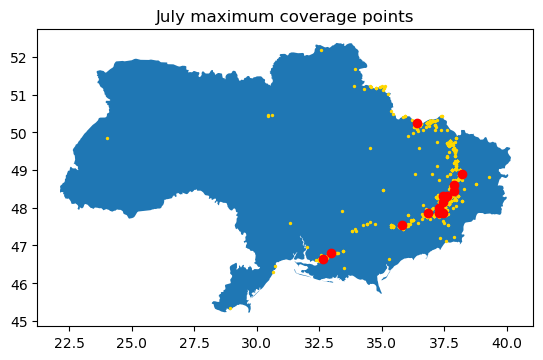

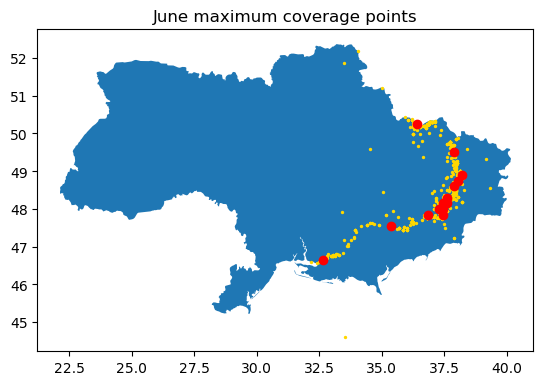

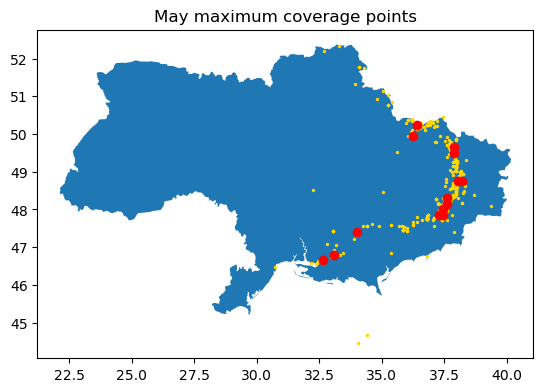

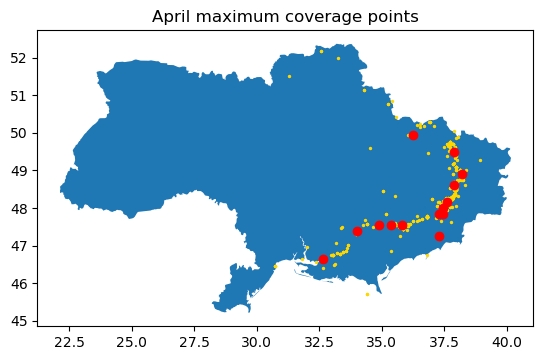

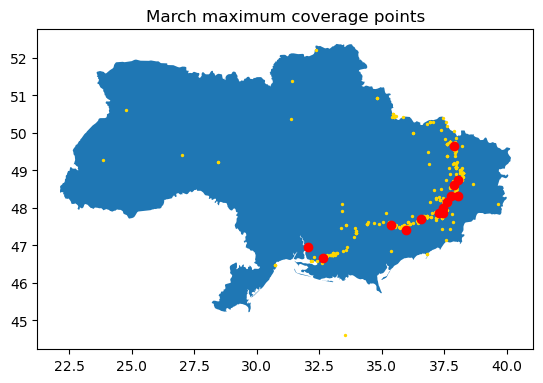

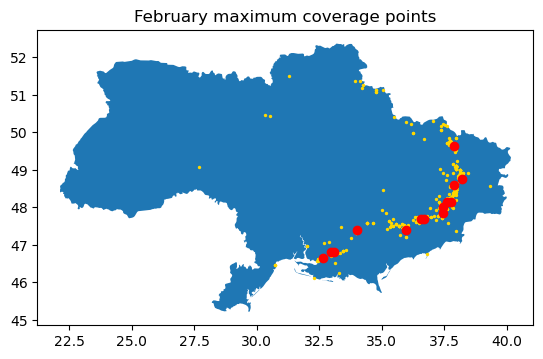

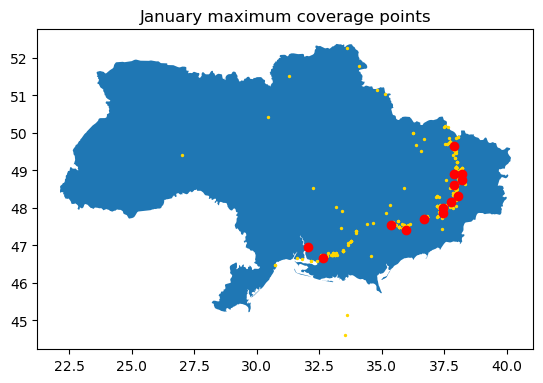

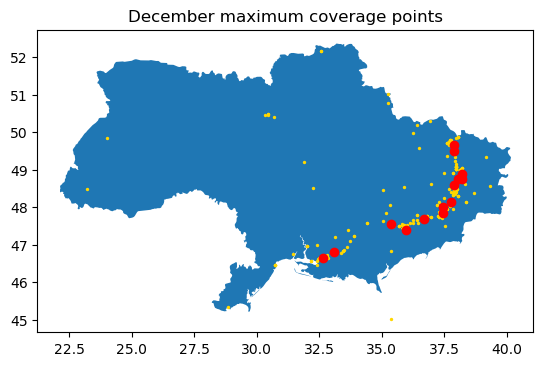

In [32]:
months = ["November","October","September","August","July","June","May","April","March","February","January","December"]

for month in months:
    places = maximum_coverage(filtered_gdf[filtered_gdf['event_date'].str.contains(month)], clipped_points, 14, .05) # .05 for the service_radius is a radius of ~5km

    f, ax = plt.subplots()
    ax.title.set_text(month + " maximum coverage points")
    ua.plot(ax=ax)
    filtered_gdf[filtered_gdf['event_date'].str.contains(month)].plot(ax=ax, color="gold", markersize=2)
    places.to_crs(ua.crs).plot(ax=ax, color="red", legend_kwds={"label": month, "orientation": "horizontal"})